# <center>Курсовая работа </center>
### <center>Студента Geek University Искусственного интеллекта</center>
### <center>Королева Артема</center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

Импорт нужных нам библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn import svm

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.simplefilter('ignore')

## Загрузка обучающего и тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - рейтинг кредитования
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [2]:
def show_plot(df, col_name):
    plt.figure(figsize=(15,6))
    y = np.linspace(0, plt.ylim()[1]*0.9, 2)
    
    plt.subplot(121)
    plt.hist(df[col_name], label=col_name, bins=50, color='#45AB45')
    plt.ylabel('Количество наблюдений')
    
    plt.subplot(122)
    sns.kdeplot(df[col_name], label=col_name, color='g', shade=True,legend=False)
    
    median = df[col_name].median()
    moda = df[col_name].mode()
    mean_ = df[col_name].mean()
    
    y = np.linspace(0, plt.ylim()[1], 2)
    plt.plot([median]*2, y, c='r',linestyle='-.', label=f'медиана ({median:.2f})')
    plt.plot([mean_]*2, y, c='m',linestyle='-.', label=f'среднее ({mean_:.2f})')
    for i in range(len(moda)):
        plt.plot([moda[i]]*2, y, c='b',linestyle='-.', label=f'мода ({moda[i]:.2f})')
    
    plt.legend(loc='upper right')
    plt.suptitle(col_name, size=12)

    
def balance_target(df, target_name):
    
    """Функция балансировки целевой переменной"""
    
    df1 = df.loc[df[target_name] == 0]
    df2 = df.loc[df[target_name] == 1]
    
    df_oversize = resample(df2, replace=True, n_samples=len(df1), random_state=42)
    df = pd.concat([df1, df_oversize])
    
    return df


def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    """Получение результатов модели классификации"""
    
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """Показывает кривые обучения и кросс-валидации"""
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    
    """Показывает три функции - Recall, Precision, F1"""
    
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """Показывает кривую обучения"""

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [3]:
df_train = pd.read_csv('G:/JN/Lessons_ipynb/course_project_train.csv')
df_test = pd.read_csv('G:/JN/Lessons_ipynb/course_project_test.csv')

In [4]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


## Изучение датасета

In [6]:
df_train.shape

(7500, 17)

In [7]:
df_test.shape

(2500, 16)

In [8]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Пропуски и в тренировочном датасете и в тестовом в одинаковых характеристиках.  
• Annual Income  
• Years in current job  
• Months since last delinquent  
• Bankruptcies  
• Credit Score  
Процентное соотношение пропусков одинаковое.

### Рассмотр и обработка каждой характеристики

**Home Ownership**

In [12]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [13]:
df_test['Home Ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

**Annual Income**

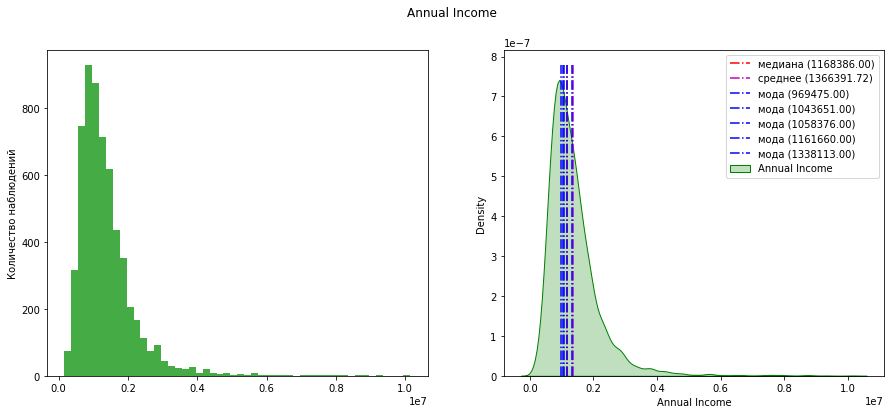

In [14]:
show_plot(df_train, 'Annual Income')

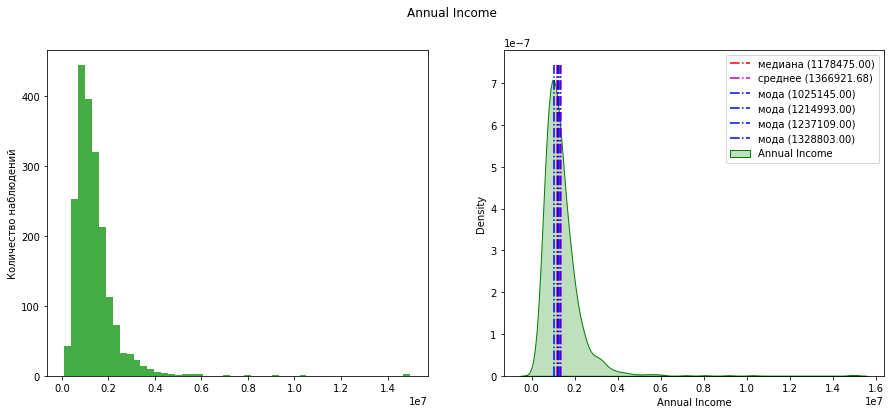

In [15]:
show_plot(df_test, 'Annual Income')

In [16]:
df_train['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

In [17]:
df_test['Annual Income'].value_counts()

1237109.0    3
1025145.0    3
1328803.0    3
1214993.0    3
992351.0     2
            ..
641687.0     1
2304624.0    1
985758.0     1
1389888.0    1
1835495.0    1
Name: Annual Income, Length: 1929, dtype: int64

In [18]:
df_train['Annual Income'].max()

10149344.0

In [19]:
df_test['Annual Income'].max()

14975610.0

Интересно, зачем людям с доходом в 10 млн. нужно брать кредит? Посмотрим на какие цели занимают такие состоятельные люди

In [20]:
df_train.loc[df_train['Annual Income'] > 8000000]['Purpose'].value_counts()

debt consolidation    5
business loan         1
home improvements     1
Name: Purpose, dtype: int64

In [21]:
df_test.loc[df_test['Annual Income'] > 8000000]['Purpose'].value_counts()

debt consolidation    2
major purchase        1
other                 1
medical bills         1
Name: Purpose, dtype: int64

В основном берут на консолидацию долга. Вроде бы обосновано. Не буду считать за выброс.

In [22]:
df_train['Annual Income'].isna().sum()

1557

In [23]:
df_test['Annual Income'].isna().sum()

513

In [24]:
df_train['Annual Income'].fillna(df_train['Annual Income'].mean(), inplace=True)

In [25]:
df_test['Annual Income'].fillna(df_train['Annual Income'].mean(), inplace=True)

**Years in current job**

In [26]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [27]:
df_test['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [28]:
df_train['Years in current job'].isna().sum()

371

In [29]:
df_test['Years in current job'].isna().sum()

86

Подавляющее большинство заемщиков проработало более 10 лет на текущей работе. Заполню пропуски медианой.

In [30]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'na'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 'na'

years_dict = {'na': 0, '< 1 year': 1, '1 year': 2, '2 years': 3, '3 years': 4, 
              '4 years': 5, '5 years': 6, '6 years': 7, '7 years': 8,
              '8 years': 9, '9 years': 10, '10+ years': 11}

df_train['Years in current job'].replace(years_dict, inplace=True)
df_test['Years in current job'].replace(years_dict, inplace=True)

df_train['Years in current job'].fillna(df_train['Years in current job'].median(), inplace=True)
df_test['Years in current job'].fillna(df_test['Years in current job'].median(), inplace=True)

**Tax Liens**

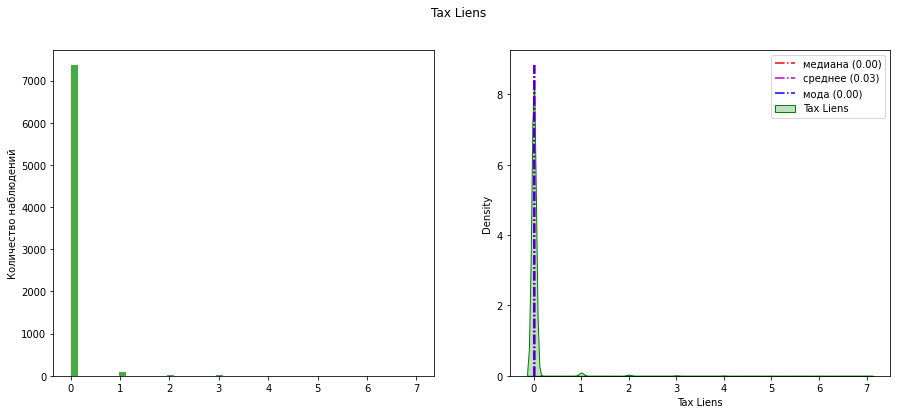

In [31]:
show_plot(df_train, 'Tax Liens')

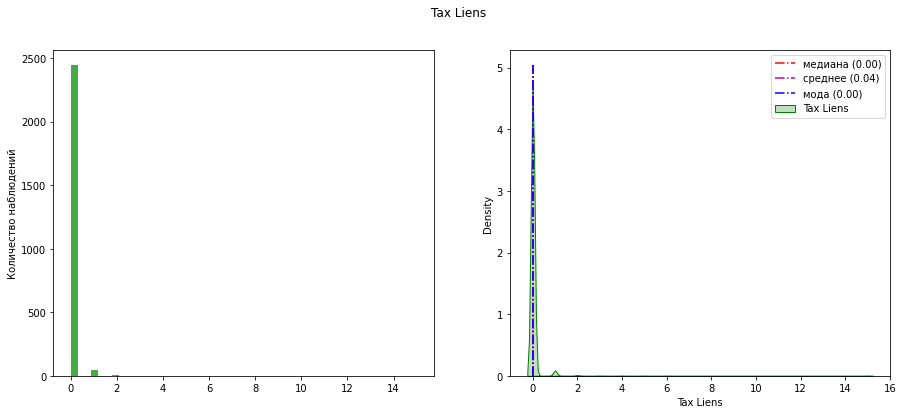

In [32]:
show_plot(df_test, 'Tax Liens')

<AxesSubplot:>

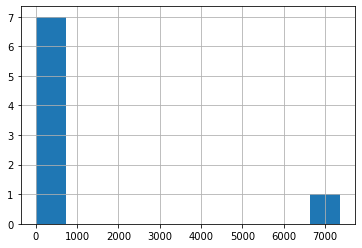

In [33]:
df_train['Tax Liens'].value_counts().hist()

<AxesSubplot:>

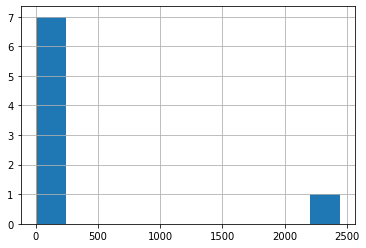

In [34]:
df_test['Tax Liens'].value_counts().hist()

In [35]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [36]:
df_test['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

**Number of Open Accounts**

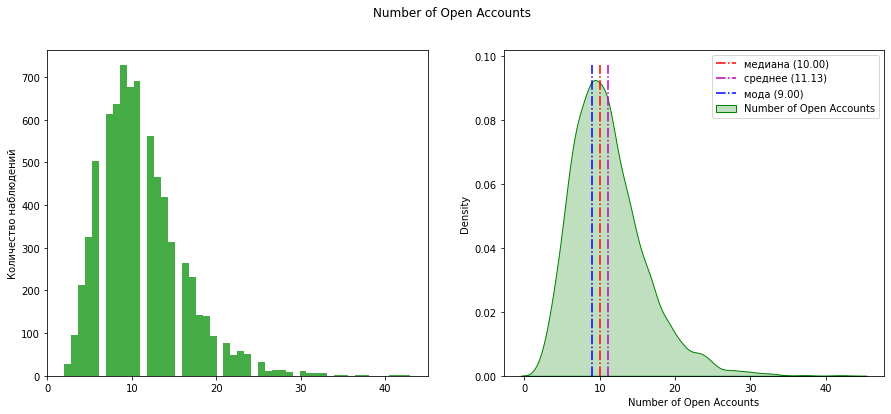

In [37]:
show_plot(df_train, 'Number of Open Accounts')

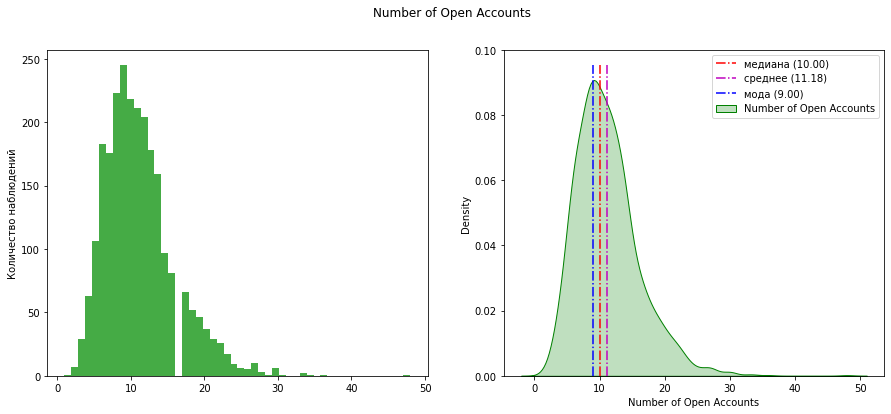

In [38]:
show_plot(df_test, 'Number of Open Accounts')

In [39]:
df_train['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [40]:
df_test['Number of Open Accounts'].value_counts()

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
48.0      1
31.0      1
1.0       1
36.0      1
29.0      1
34.0      1
Name: Number of Open Accounts, dtype: int64

Оставлю его, как есть.

**Years of Credit History**

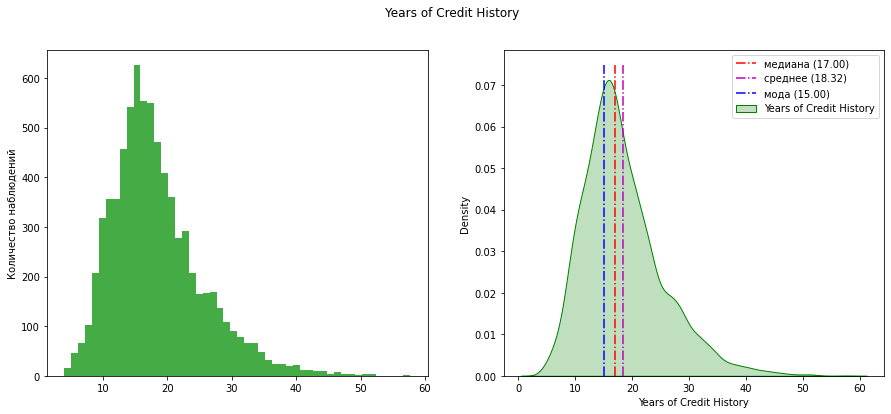

In [41]:
show_plot(df_train, 'Years of Credit History')

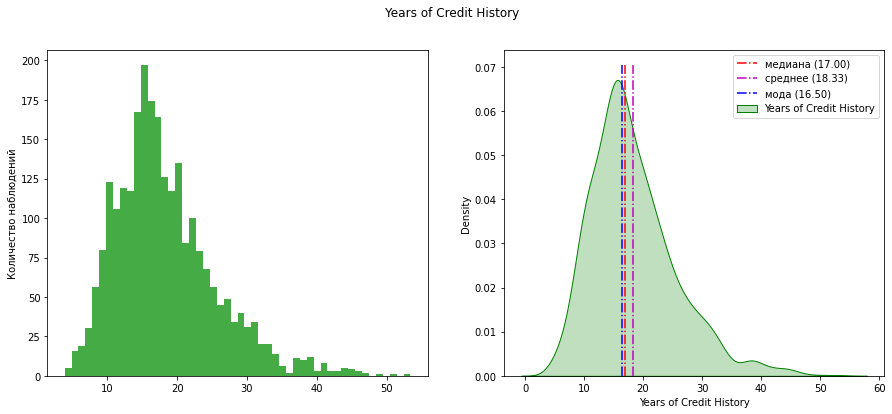

In [42]:
show_plot(df_test, 'Years of Credit History')

In [43]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

In [44]:
df_test['Years of Credit History'].value_counts()

16.5    35
14.0    33
16.0    32
17.0    30
17.5    28
        ..
38.0     1
53.4     1
42.0     1
6.8      1
5.6      1
Name: Years of Credit History, Length: 345, dtype: int64

Неплохое распределение, оставляю.

**Maximum Open Credit**

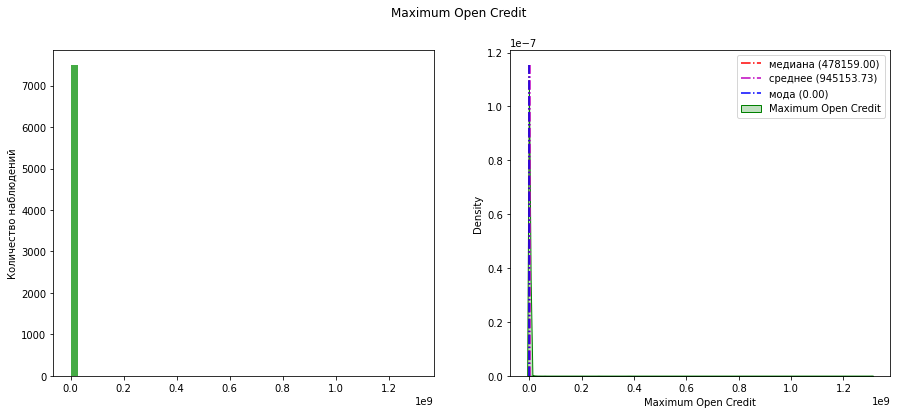

In [45]:
show_plot(df_train, 'Maximum Open Credit')

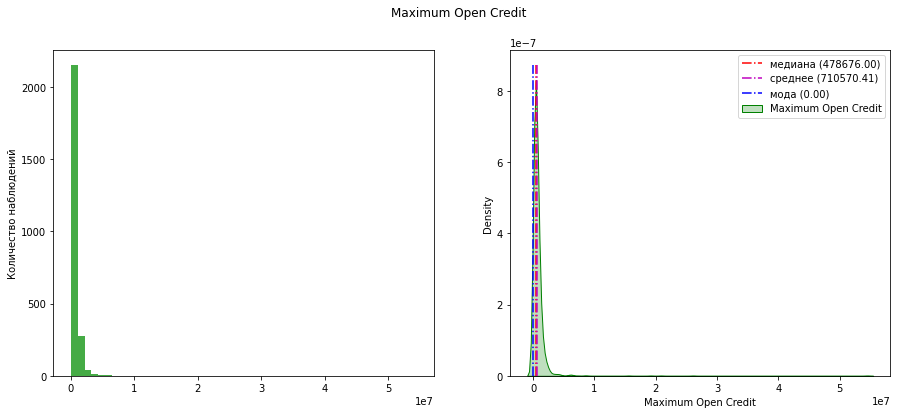

In [46]:
show_plot(df_test, 'Maximum Open Credit')

In [47]:
df_train['Maximum Open Credit'].value_counts().sort_index(ascending=False).sort_values(ascending=False)

0.000000e+00    65
3.191100e+05     5
3.419240e+05     3
4.874980e+05     3
3.491400e+05     3
                ..
3.647820e+05     1
3.647380e+05     1
3.644520e+05     1
3.644300e+05     1
1.304726e+09     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [48]:
df_train.loc[df_train['Maximum Open Credit'] > 1e8, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].mean()

In [49]:
df_test['Maximum Open Credit'].value_counts().sort_index(ascending=False).sort_values(ascending=False)

0.0           14
474298.0       2
1165516.0      2
617672.0       2
188078.0       2
              ..
351714.0       1
352154.0       1
352352.0       1
352506.0       1
54484386.0     1
Name: Maximum Open Credit, Length: 2435, dtype: int64

In [50]:
df_test.loc[df_test['Maximum Open Credit'] > 1e8, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].mean()

In [51]:
df_train['Maximum Open Credit'].isna().sum()

0

Выбросил слишком большие значения

**Number of Credit Problems**

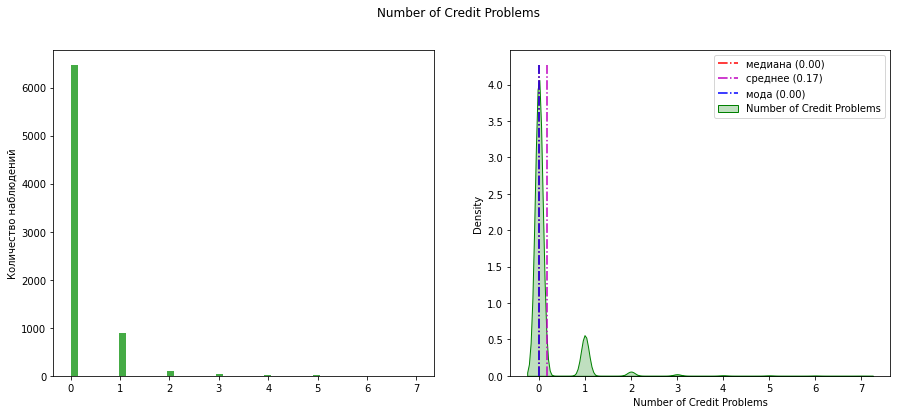

In [52]:
show_plot(df_train, 'Number of Credit Problems')

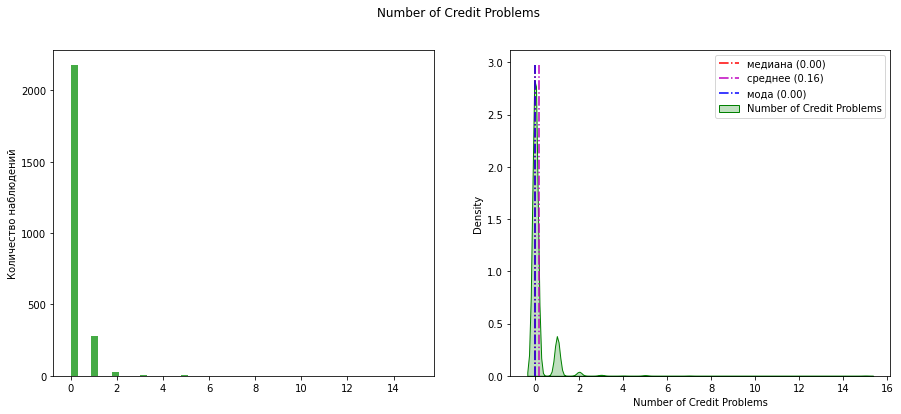

In [53]:
show_plot(df_test, 'Number of Credit Problems')

Оставляю.

In [54]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [55]:
df_test['Number of Credit Problems'].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

# **Months since last delinquent**

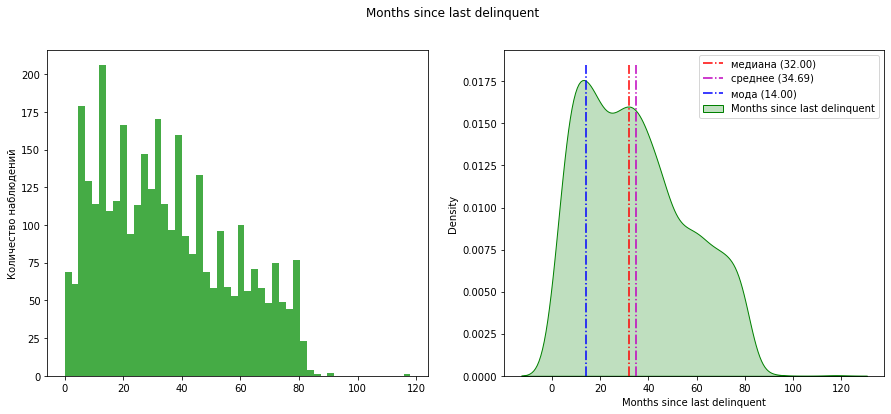

In [56]:
show_plot(df_train, 'Months since last delinquent')

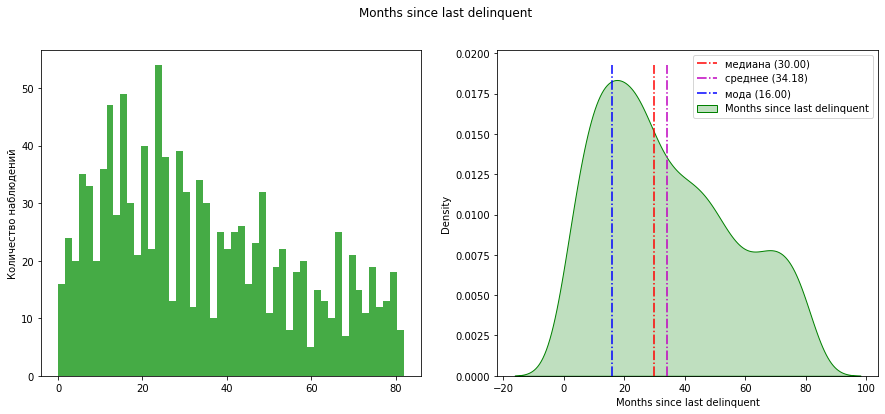

In [57]:
show_plot(df_test, 'Months since last delinquent')

In [58]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [59]:
df_test['Months since last delinquent'].value_counts()

16.0    30
23.0    28
14.0    28
24.0    26
13.0    25
        ..
60.0     5
81.0     5
64.0     5
65.0     5
82.0     3
Name: Months since last delinquent, Length: 83, dtype: int64

In [60]:
df_train['Months since last delinquent'].isna().sum()

4081

In [61]:
df_test['Months since last delinquent'].isna().sum()

1358

In [62]:
df_train['Months since last delinquent'].fillna(0, inplace=True)

In [63]:
df_test['Months since last delinquent'].fillna(0, inplace=True)

**Bankruptcies**

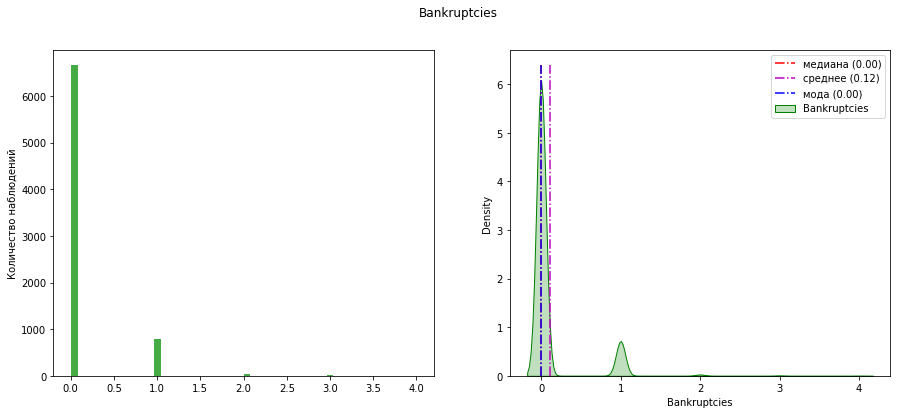

In [64]:
show_plot(df_train, 'Bankruptcies')

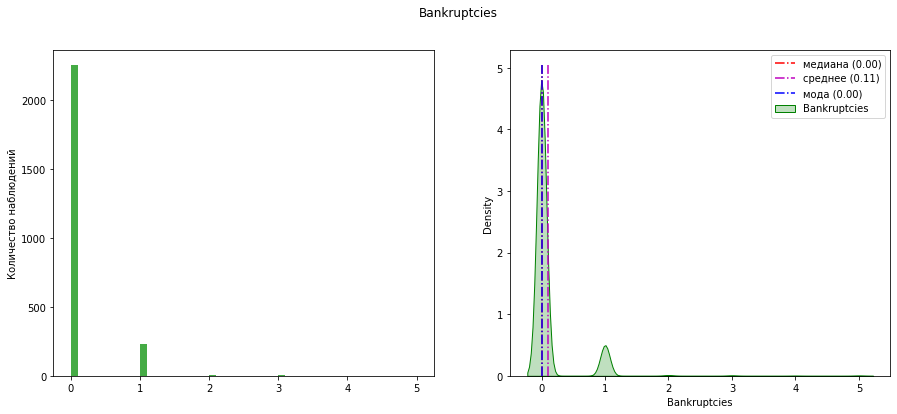

In [65]:
show_plot(df_test, 'Bankruptcies')

In [66]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [67]:
df_test['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [68]:
df_train['Bankruptcies'].isna().sum()

14

In [69]:
df_test['Bankruptcies'].isna().sum()

3

Заменю на медиану.

In [70]:
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace=True)

In [71]:
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].median(), inplace=True)

**Purpose**

In [72]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [73]:
df_train.loc[df_train['Purpose'] == 'renewable energy']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2223,Home Mortgage,1.366392e+06,11,0.0,3.0,22.6,295218.0,0.0,0.0,0.0,renewable energy,Long Term,215468.0,198341.0,6421.0,NaN,1
7082,Own Home,1.366392e+06,4,0.0,14.0,27.9,182094.0,0.0,25.0,0.0,renewable energy,Short Term,21912.0,49533.0,9878.0,NaN,1


In [74]:
df_train.loc[df_train['Purpose'] == 'renewable energy', 'Purpose'] = df_train['Purpose'].mode()

In [75]:
df_train['Purpose'].mode()

0    debt consolidation
dtype: object

In [76]:
df_train['Purpose'].fillna('debt consolidation', inplace=True)

In [77]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

**Term**

In [78]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [79]:
df_test['Term'].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

Вроде бы, все хорошо.

**Current Loan Amount**

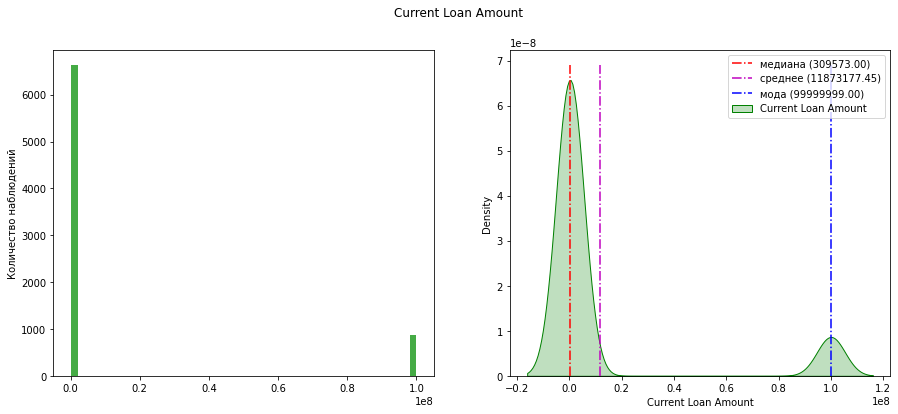

In [80]:
show_plot(df_train, 'Current Loan Amount')

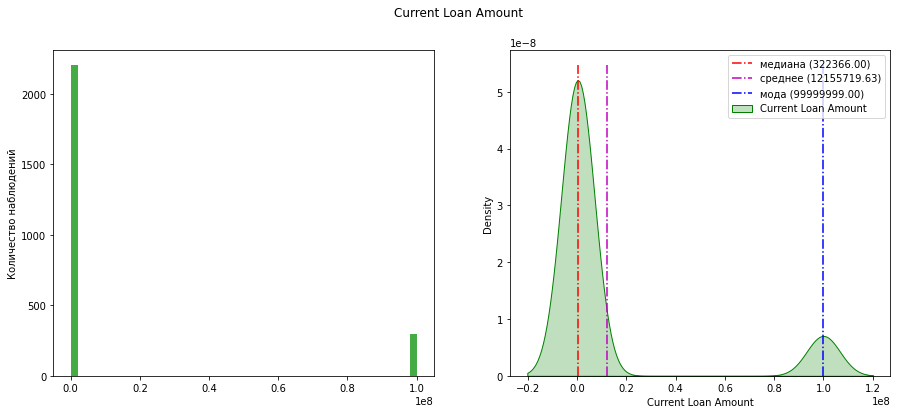

In [81]:
show_plot(df_test, 'Current Loan Amount')

**Current Credit Balance**

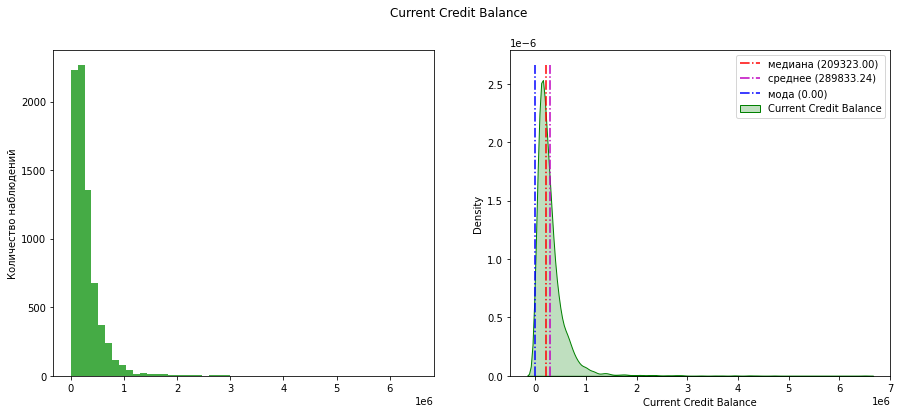

In [82]:
show_plot(df_train, 'Current Credit Balance')

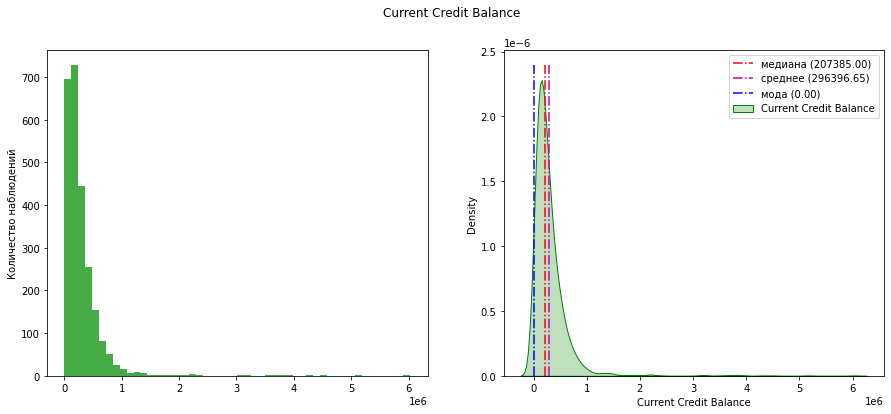

In [83]:
show_plot(df_test, 'Current Credit Balance')

Выглядит неплохо.

**Monthly Debt**

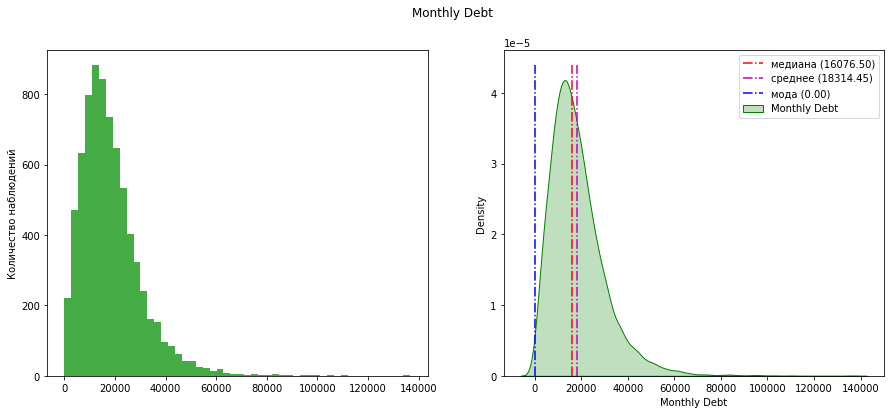

In [84]:
show_plot(df_train, 'Monthly Debt')

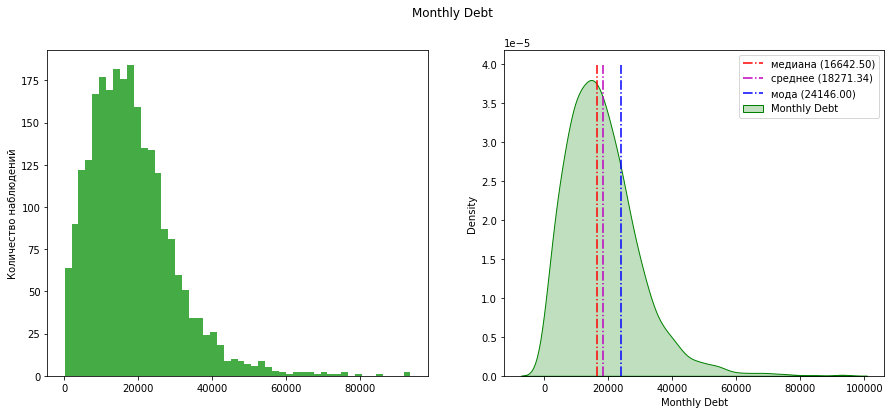

In [85]:
show_plot(df_test, 'Monthly Debt')

Аналогично.

**Credit Score**

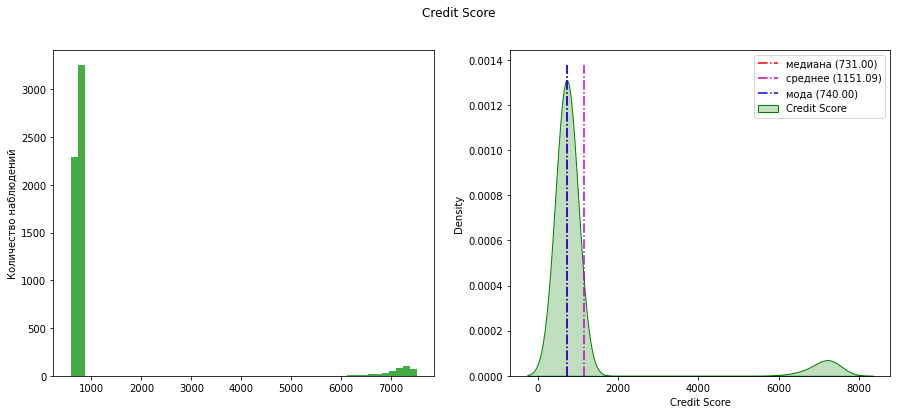

In [86]:
show_plot(df_train, 'Credit Score')

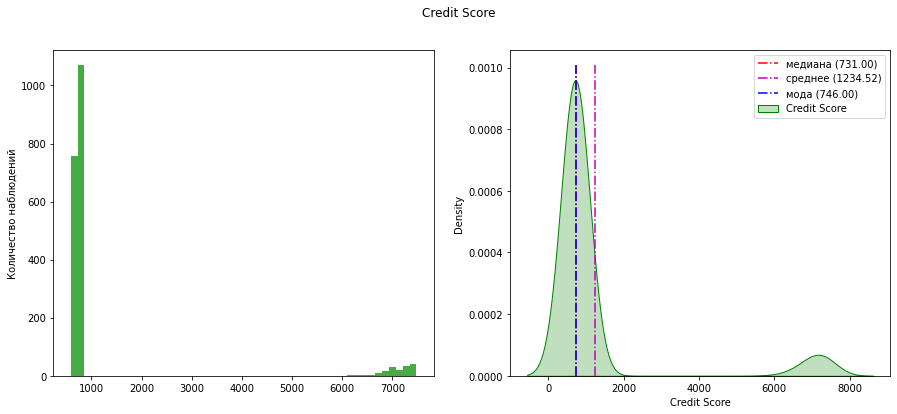

In [87]:
show_plot(df_test, 'Credit Score')

In [88]:
df_train['Credit Score'].isna().sum()

1557

In [89]:
df_test['Credit Score'].isna().sum()

513

In [90]:
df_train['Credit Score'].fillna(0, inplace=True)

In [91]:
df_test['Credit Score'].fillna(0, inplace=True)

Финальный просмотр пропусков

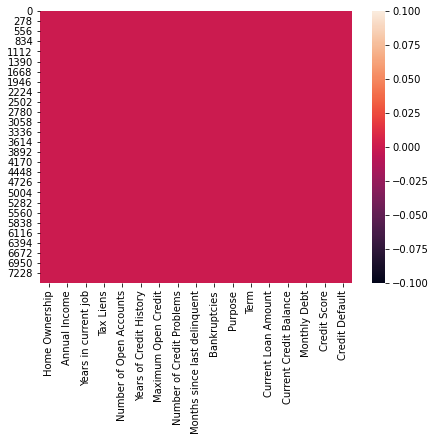

In [92]:
cols = df_train.columns
plt.figure(figsize=(7,5))
sns.heatmap(df_train[cols].isnull())
plt.show()

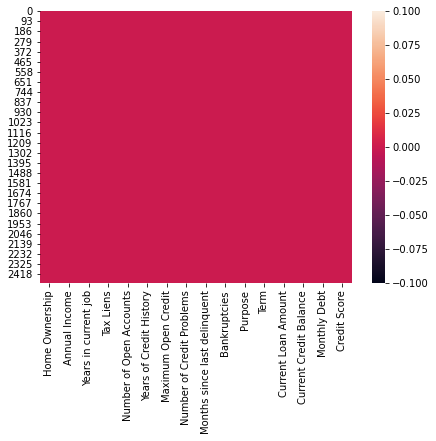

In [93]:
cols = df_test.columns
plt.figure(figsize=(7,5))
sns.heatmap(df_test[cols].isnull())
plt.show()

**Карта корелляций**

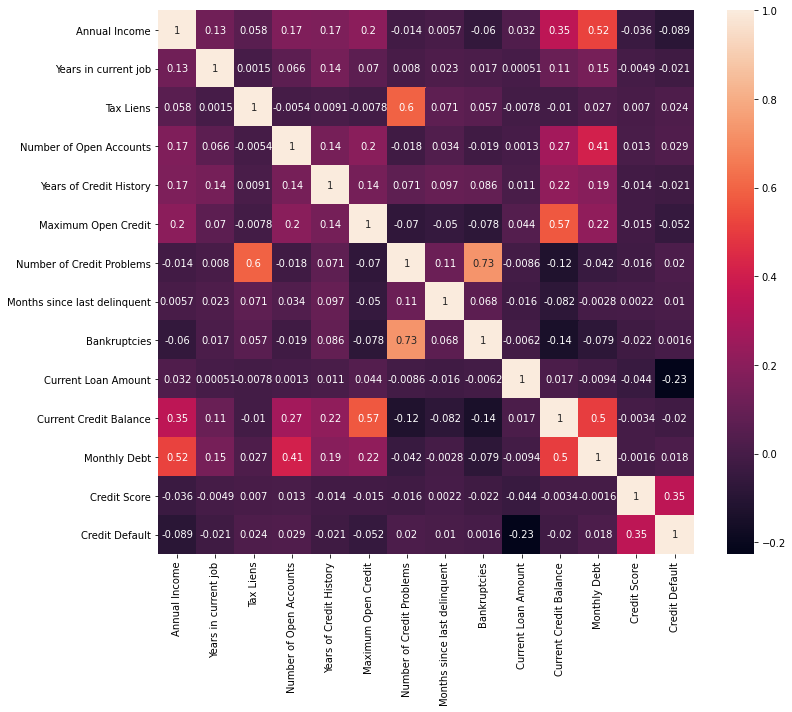

In [94]:
plt.figure(figsize=(12,10))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

Перевод категорийных признаков в one_hot_encoding

In [95]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [96]:
for cat_colname in df_test.select_dtypes(include='object').columns[:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

**Выделение целевой переменной и групп признаков**

In [97]:
df_train.drop(columns=['Home Ownership', 'Purpose', 'Term'], axis=1, inplace=True)
df_test.drop(columns=['Home Ownership', 'Purpose', 'Term'], axis=1, inplace=True)

In [98]:
df_train['s_LoanToIncome'] = df_train['Current Loan Amount'] / df_train['Annual Income']
df_train['s_DebtToIncome'] = df_train['Monthly Debt'] / df_train['Annual Income']

df_test['s_LoanToIncome'] = df_test['Current Loan Amount'] / df_test['Annual Income']
df_test['s_DebtToIncome'] = df_test['Monthly Debt'] / df_test['Annual Income']

In [99]:
scaler = StandardScaler()

scaler.fit(df_train.loc[:, df_train.columns != 'Credit Default'])
scaler.fit(df_test)

StandardScaler()

**Балансировка целевой переменной**

In [100]:
df_train = balance_target(df_train, 'Credit Default')

**Разбиение на train и test**

In [101]:
X = df_train.drop(columns=['Credit Default'], axis=1)
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**CatBoost**

In [102]:
model_catb = catb.CatBoostClassifier(silent=True)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      4047
           1       0.93      0.92      0.92      4033

    accuracy                           0.92      8080
   macro avg       0.92      0.92      0.92      8080
weighted avg       0.92      0.92      0.92      8080

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1340
           1       0.81      0.81      0.81      1354

    accuracy                           0.81      2694
   macro avg       0.81      0.81      0.81      2694
weighted avg       0.81      0.81      0.81      2694

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1081   259
1                256  1098


**LightGBM**

In [103]:
model_lgbm = lgbm.LGBMClassifier()
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4047
           1       0.94      0.93      0.93      4033

    accuracy                           0.93      8080
   macro avg       0.93      0.93      0.93      8080
weighted avg       0.93      0.93      0.93      8080

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1340
           1       0.80      0.82      0.81      1354

    accuracy                           0.81      2694
   macro avg       0.81      0.81      0.81      2694
weighted avg       0.81      0.81      0.81      2694

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1060   280
1                243  1111


**XGBoost**

In [104]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4047
           1       0.98      0.98      0.98      4033

    accuracy                           0.98      8080
   macro avg       0.98      0.98      0.98      8080
weighted avg       0.98      0.98      0.98      8080

TEST

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1340
           1       0.82      0.89      0.85      1354

    accuracy                           0.84      2694
   macro avg       0.85      0.84      0.84      2694
weighted avg       0.85      0.84      0.84      2694

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1071   269
1                150  1204


**Подбор гиперпараметров для XGBoost**

In [105]:
params = {
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
    'max_depth'        : [8, 10, 12, 15, 30, 45, 55],
    'min_child_weight' : [1, 3, 5, 7],
    'gamma'            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
    'subsample'        : [0.6, 0.8, 1.0]
}

model = xgb.XGBClassifier()

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True)

rand_search = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=skf.split(X_train, y_train),
    verbose=3
)

rand_search.fit(X_train, y_train)


print('\n best estimator:')
print(rand_search.best_estimator_)
print('\n best hyperparameters:')
print(rand_search.best_params_)

y_train_pred = rand_search.predict(X_train)
y_test_pred = rand_search.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    8.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.6s finished



 best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=55,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

 best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 55, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.5}
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4047
           1       1.00      1.00      1.00      4033

    accuracy                           1.00      8080
   macro avg       1.00      1.0

In [106]:
final_model = rand_search.best_estimator_

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4047
           1       1.00      1.00      1.00      4033

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080

TEST

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1340
           1       0.86      0.91      0.88      1354

    accuracy                           0.88      2694
   macro avg       0.88      0.88      0.88      2694
weighted avg       0.88      0.88      0.88      2694

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1134   206
1                116  1238


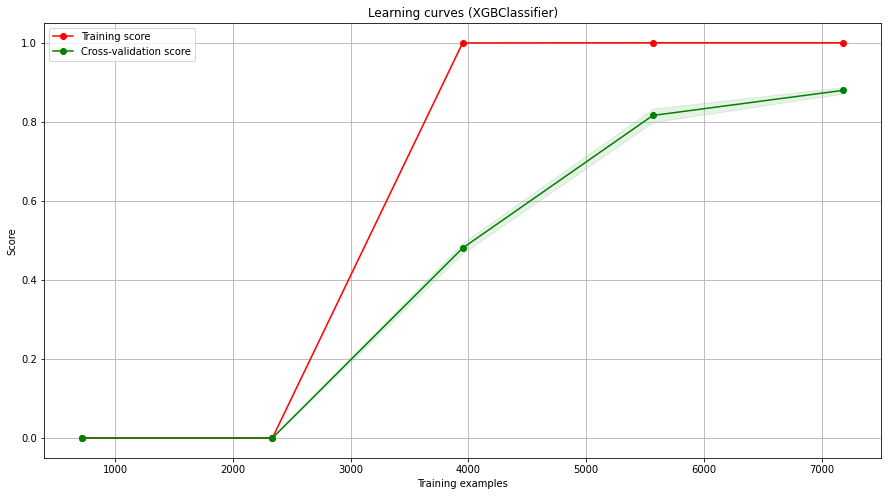

In [107]:
show_learning_curve_plot(final_model, X, y)

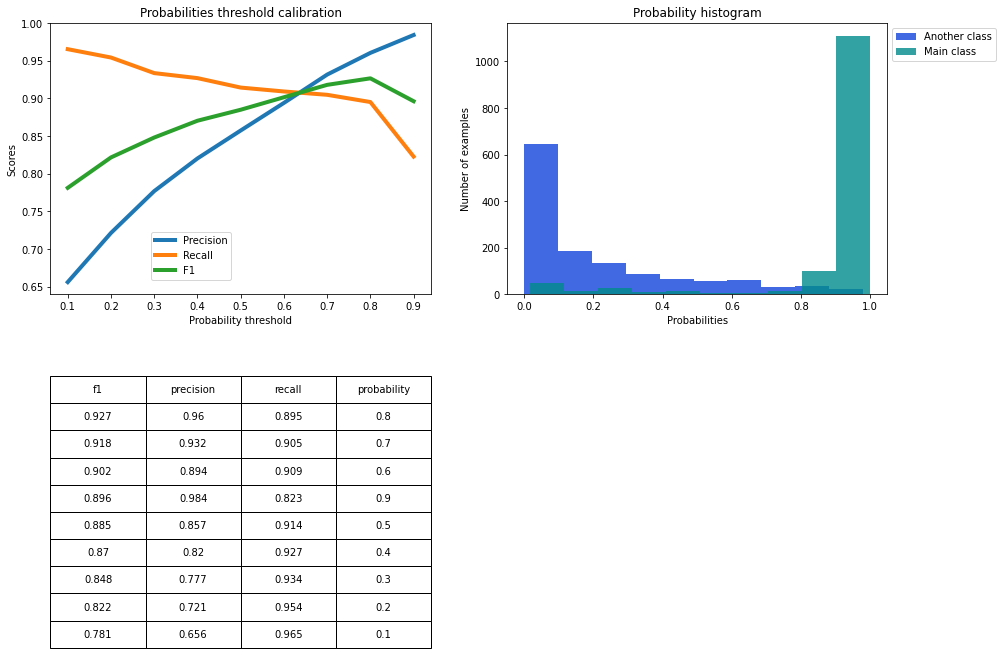

In [108]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [109]:
y_pred = final_model.predict(df_test)

In [110]:
pd.DataFrame(y_pred, columns = ['Credit Default']).to_csv('G:/JN/Lessons_ipynb/AKorolev_predictions.csv', sep=',', index=False)